In [91]:
from collections import defaultdict
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from scipy import stats as st
from tqdm import tqdm_notebook
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [93]:
#bert_models = ["MNLI", "QQP", "SST", "SQuAD", "LM", "LM_contentonly", "LM_lmonly", "LM_scrambled", "LM_contentonly_scrambled", "LM_lmonly_scrambled"]
bert_models = ["SQuAD", "LM", "LM_scrambled"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8]
steps = list(range(5, 255, 5))

In [94]:
PCA_DIM = 256

In [95]:
# Load model encoding data.
encodings = {}
for model, run in tqdm_notebook(list(itertools.product(bert_models, target_runs)), desc="Loading model runs"):
    encoding_glob = "encodings.%s.%s.%s-run%i-*.npy" % (finetune_desc, bert_base_model, model, run)
    for encoding_path in tqdm_notebook(list(bert_encoding_path.glob(encoding_glob)), desc="steps", leave=False):
        step = int(re.findall(r"-(\d+)\.npy$", encoding_path.name)[0])
        if step not in [steps[0], steps[-1]]:
            continue

        try:
            encodings[model, run, step] = util.load_encodings([encoding_path], project=PCA_DIM)
        except FileNotFoundError:
            continue

In [96]:
# Load pretrained model encodings.
encoding_path = bert_encoding_path / ("encodings.%s.npy" % (bert_base_model))
baseline_encoding = util.load_encodings([encoding_path], project=PCA_DIM)

## Sentence divergences

In [97]:
divergences = defaultdict(list)
for (model, run, step), m_encodings in encodings.items():
    if step != steps[-1]: continue
    divergences[model].append(np.linalg.norm(m_encodings - baseline_encoding, axis=1))

In [98]:
divergences = {k: pd.DataFrame(np.stack(v).T).rename(columns=lambda r: "run_%i" % r) for k, v in divergences.items()}

In [99]:
divergences = pd.concat(divergences).sort_index()
divergences.index.names = ["model", "sentence"]
divergences.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


run_0     run_1      run_2     run_3     run_4     run_5  \
model sentence                                                                 
LM    0          7.494736  6.348477   7.357879  5.701009  7.338653  7.768169   
      1          7.168331  8.213109   7.908254  7.727065  7.234612  7.219440   
      2          8.212467  8.613698   8.541066  7.972699  7.665820  7.715042   
      3          7.758420  9.397472   8.759999  7.236808  8.552815  8.255716   
      4         10.170087  9.181191  10.922810  8.464636  9.508505  9.920853   

                    run_6     run_7  
model sentence                       
LM    0          9.255251  5.833636  
      1          9.781015  7.688496  
      2          8.866532  8.231302  
      3          9.909550  8.622805  
      4         10.671535  8.967173

In [100]:
divergences = pd.melt(divergences.reset_index(), id_vars=["model", "sentence"], var_name="run", value_name="dist")
divergences.head()

,model,sentence,run,dist
0,LM,0,run_0,7.494736
1,LM,1,run_0,7.168331
2,LM,2,run_0,8.212467
3,LM,3,run_0,7.758420
4,LM,4,run_0,10.170087


In [101]:
# Normalize by average sentence divergence per run.
div_ranges = divergences.groupby(["model", "run"]).dist.agg(["min", "max"])
divergences = divergences.set_index(["model", "run"]).sort_index()
divergences["dist_norm"] = (divergences.dist - div_ranges["min"]) / (div_ranges["max"] - div_ranges["min"])
divergences = divergences.reset_index()

In [102]:
divergences.head()

,model,run,sentence,dist,dist_norm
0,LM,run_0,0,7.494736,0.286150
1,LM,run_0,1,7.168331,0.238632
2,LM,run_0,2,8.212467,0.390636
3,LM,run_0,3,7.758420,0.324537
4,LM,run_0,4,10.170087,0.675624


In [103]:
mean_div = divergences.groupby("sentence").apply(lambda xs: xs.groupby("model").dist_norm.agg("mean"))
mean_div.head()

model,LM,LM_scrambled,SQuAD
sentence,,,
0,0.239921,0.153455,0.381667
1,0.358050,0.295605,0.398559
2,0.414423,0.331747,0.371983
3,0.467778,0.453131,0.504142
4,0.655663,0.434289,0.835330


In [104]:
mean_div["max_dist"] = mean_div.apply(lambda ks: ks.max(), axis=1)
mean_div = mean_div.sort_values("max_dist", ascending=False)
mean_div.head(15)

model,LM,LM_scrambled,SQuAD,max_dist
sentence,,,,
222,0.864077,0.957880,0.935247,0.957880
352,0.766478,0.891088,0.917092,0.917092
351,0.910969,0.785840,0.904788,0.910969
355,0.619102,0.877666,0.666609,0.877666
4,0.655663,0.434289,0.835330,0.835330
113,0.649254,0.827200,0.635019,0.827200
114,0.615328,0.823906,0.579975,0.823906
243,0.662052,0.432777,0.817361,0.817361
232,0.797211,0.802403,0.805779,0.805779


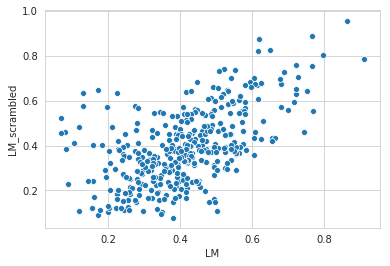

In [105]:
sns.scatterplot(x="LM", y="LM_scrambled", data=mean_div)

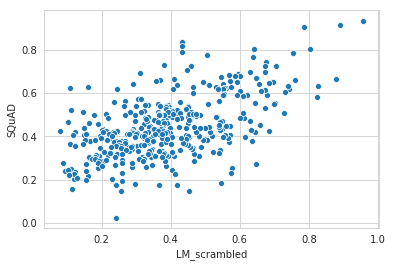

In [107]:
sns.scatterplot(x="LM_scrambled", y="SQuAD", data=mean_div)